In [1]:
from config import DEVICE, BATCH_SIZE

## `torch` dataset and loader formation

In [2]:
import torch
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader

from config import DATASET, IND_CLASSES, OOD_CLASSES


resnet18_preprocess = v2.Compose([
    v2.Resize(224, interpolation=InterpolationMode.BILINEAR),
    # v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),  # to [0, 1]
    v2.Normalize(mean=DATASET.MEAN,
                 std=DATASET.STD)  # to ([0, 1]^3 - mean) / std
])

train_dataset = DATASET(root='./data', include_classes=IND_CLASSES,
                        train=True, transform=resnet18_preprocess)
test_dataset = DATASET(root='./data', include_classes=IND_CLASSES,
                       train=False, transform=resnet18_preprocess)
OOD_dataset = DATASET(root='./data', include_classes=OOD_CLASSES,
                       train=True, transform=resnet18_preprocess)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8, pin_memory=True)
OOD_loader = DataLoader(OOD_dataset, batch_size=BATCH_SIZE, num_workers=8, pin_memory=True)

CIFAR-10 images already extracted: 50000 train, 10000 test images found.
CIFAR-10 images already extracted: 50000 train, 10000 test images found.
CIFAR-10 images already extracted: 50000 train, 10000 test images found.


## Total loss definition

In [3]:
import torch

from adversaries import FGSM_attack

from config import CLS_LOSS_FN, ENERGY_ENFORCEMENT_FN


def compute_loss(model, x, y, alpha_FGSM,
                 epsilon_energy, delta_energy, λ_adv, λ_energy):
    
    logits_clean, E_clean = model(x)
    L_clean = CLS_LOSS_FN(logits_clean, y, reduction="mean")

    x_adv = FGSM_attack(model, x, y, alpha_FGSM)
    logits_adv, E_adv = model(x_adv)
    L_adv = torch.tensor(0)
    if λ_adv != 0:
        L_adv = CLS_LOSS_FN(logits_adv, y, reduction="mean")

    L_energy = torch.tensor(0)
    if λ_energy != 0:
        E_clean_penalty = ENERGY_ENFORCEMENT_FN(E_clean - epsilon_energy)
        E_adv_penalty = ENERGY_ENFORCEMENT_FN(epsilon_energy + delta_energy - E_adv)
        L_energy = E_clean_penalty.mean() + E_adv_penalty.mean()

    L_total = L_clean + λ_adv*L_adv + λ_energy*L_energy

    metrics = {
        'L_clean': L_clean.item(),
        'L_adv': λ_adv*L_adv.item(),
        'L_energy': λ_energy*L_energy.item(),
        'E_clean': E_clean.mean().item(),
        'E_adv': E_adv.mean().item(),
    }

    return L_total, metrics

## Model training

In [4]:
from tqdm import tqdm
import torch.optim as optim

from config import MODEL_CLASS

from config import TRAIN_FGSM_ALPHA, NUM_EPOCHS, LR
from config import EPSILON_ENERGY, DELTA_ENERGY, λ_ADV, λ_ENERGY


model = MODEL_CLASS(len(IND_CLASSES)).to(DEVICE)
# model.load_state_dict(torch.load("resnet18_16aug_parallel_inverted_energy.pt"))
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    model.train()
    total_metrics = {'L_clean': 0, 'L_adv': 0, 'L_energy': 0, 'E_clean': 0, 'E_adv': 0}
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for x, y in progress_bar:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        loss, metrics = compute_loss(model, x, y, TRAIN_FGSM_ALPHA,
                                     EPSILON_ENERGY, DELTA_ENERGY, λ_ADV, λ_ENERGY)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k in total_metrics:
            total_metrics[k] += metrics[k]

        progress_bar.set_postfix(metrics)

    print(f"[Epoch {epoch+1}]")
    for k in total_metrics:
        print(f"  {k}: {total_metrics[k] / len(train_loader):.4f}")

100%|█| 2813/2813 [10:07<00:00,  4.63it/s, L_clean=2.23, L_adv=2.47, L_energy=7.


[Epoch 1]
  L_clean: 2.0821
  L_adv: 2.2651
  L_energy: 7.5177
  E_clean: 9.3451
  E_adv: 9.4725


100%|█| 2813/2813 [17:43<00:00,  2.64it/s, L_clean=1.66, L_adv=1.9, L_energy=0, 


[Epoch 2]
  L_clean: 1.8838
  L_adv: 2.0310
  L_energy: 2.8051
  E_clean: 4.6201
  E_adv: 35.1288


100%|█| 2813/2813 [21:18<00:00,  2.20it/s, L_clean=1.58, L_adv=1.59, L_energy=0,


[Epoch 3]
  L_clean: 1.5087
  L_adv: 1.7589
  L_energy: 0.0041
  E_clean: 0.5397
  E_adv: 53.9963


100%|█| 2813/2813 [21:28<00:00,  2.18it/s, L_clean=1.68, L_adv=1.69, L_energy=0,


[Epoch 4]
  L_clean: 1.2893
  L_adv: 1.4990
  L_energy: 0.0007
  E_clean: 0.3841
  E_adv: 49.9022


100%|█| 2813/2813 [21:31<00:00,  2.18it/s, L_clean=0.509, L_adv=1.12, L_energy=0


[Epoch 5]
  L_clean: 1.1053
  L_adv: 1.4178
  L_energy: 0.0196
  E_clean: 0.3855
  E_adv: 52.1185


100%|█| 2813/2813 [21:48<00:00,  2.15it/s, L_clean=0.706, L_adv=1.33, L_energy=0


[Epoch 6]
  L_clean: 0.9442
  L_adv: 1.1453
  L_energy: 0.0002
  E_clean: 0.4436
  E_adv: 49.6304


100%|█| 2813/2813 [21:57<00:00,  2.13it/s, L_clean=0.714, L_adv=0.5, L_energy=0,

[Epoch 7]
  L_clean: 0.8361
  L_adv: 0.9897
  L_energy: 0.0022
  E_clean: 0.3411
  E_adv: 62.4267


In [5]:
torch.save(model.state_dict(), "resnet18_aug21_OOD.pt")

## Evaluation

In [3]:
from config import MODEL_CLASS

model = MODEL_CLASS(len(IND_CLASSES)).to(DEVICE)
model.load_state_dict(torch.load("resnet18_aug21_OOD.pt"))

<All keys matched successfully>

Evaluating: 100%|█████████████████████████████| 313/313 [00:08<00:00, 35.98it/s]


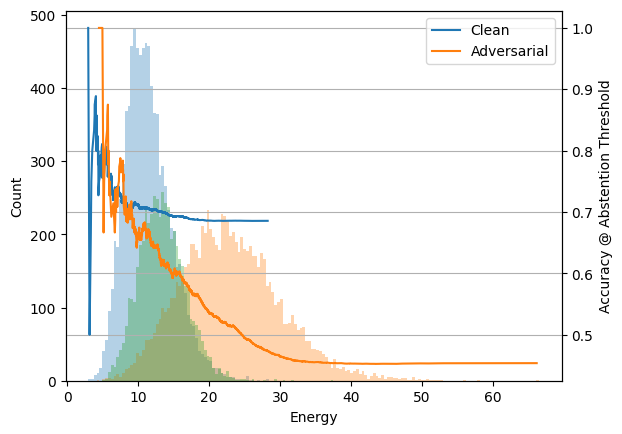

In [4]:
from evaluation import *

clean_E, adv_E, clean_res, adv_res = results_and_energy(model, test_loader)
OOD_E = energy(model, OOD_loader)
clean_E, clean_acc_at_thresh = evaluate_at_threshold(clean_E, clean_res, reject_lower_than_threshold=False)
adv_E, adv_acc_at_thresh = evaluate_at_threshold(adv_E, adv_res, reject_lower_than_threshold=False)

energies = {"E_clean": clean_E, "E_adv": adv_E, "E_OOD": OOD_E}
curves = {"Clean": (clean_E, clean_acc_at_thresh),
          "Adversarial": (adv_E, adv_acc_at_thresh)}

evaluation_figure(energies, curves)